In [22]:
import torch
import torchvision
from torch import nn, optim
import cv2
import numpy as np
import json
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

from model.cnn_model import HOCNN

In [23]:
model = "HICO/v1/"
#checkpoint_path = "v1_checkpoint_65_epoch_97_62val.pth"
checkpoint_path = "checkpoint_20_epoch.pth"
#checkpoint_path = "checkpoint_10_epoch.pth"

PATH = "checkpoints/" + model + "epoch_train/" + checkpoint_path

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(PATH, map_location=device)
model = HOCNN()
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print("model loaded")

model loaded


In [25]:
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn.eval()
print("faster rcnn loaded")

faster rcnn loaded


In [26]:
coco_dict = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

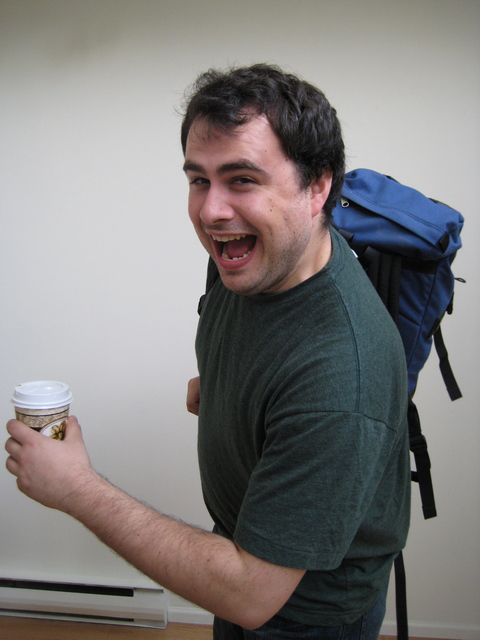

In [49]:
IMG_PATH = "datasets/hico/images/test2015/HICO_test2015_00000005.jpg"
#IMG_PATH = "assets/test1.jpg"
im = Image.open(IMG_PATH)
display(im)

In [50]:
src = cv2.imread(IMG_PATH)
src = src/255
img_tensor = torch.from_numpy(src)
img_tensor = img_tensor.permute([2,0,1]).float().to(device) # chw format
rcnn_input = [img_tensor]

In [51]:
out = faster_rcnn(rcnn_input)[0]

In [52]:
human_bboxes, object_bboxes = [], []
object_dic = {}
for i in range(len(out['boxes'])):
    if out['scores'][i] < .9:
        break
    bbox = list(map(int, out['boxes'][i]))
    if out['labels'][i] == 1: # human
        human_bboxes.append(bbox)
    else: 
        object_bboxes.append(bbox)
        object_dic[coco_dict[out['labels'][i]]] = bbox
        
print(human_bboxes, object_bboxes)
print(object_dic)

[[21, 61, 441, 625]] []
{}


In [53]:
# apply masks
src = cv2.imread(IMG_PATH)
human_mask = np.zeros_like(src)
for bbox in human_bboxes:
    cv2.rectangle(human_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
human_bbox_img = cv2.bitwise_and(src, human_mask, mask=None)

obj_mask = np.zeros_like(src)
pairwise_mask = human_mask
for bbox in object_bboxes:
    cv2.rectangle(obj_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
    cv2.rectangle(pairwise_mask, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), thickness=-1)
obj_bbox_img = cv2.bitwise_and(src, obj_mask, mask=None)
pairwise_bbox_img = cv2.bitwise_and(src, pairwise_mask, mask=None)

# resize images
human_bbox_img = cv2.resize(human_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
obj_bbox_img = cv2.resize(obj_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
pairwise_bbox_img = cv2.resize(pairwise_bbox_img, (64, 64), interpolation=cv2.INTER_AREA)
#pose_img = cv2.resize(pose_img, (64, 64), interpolation=cv2.INTER_AREA)

human_bbox_img = torch.from_numpy(human_bbox_img).to(device)
obj_bbox_img = torch.from_numpy(obj_bbox_img).to(device)
pairwise_bbox_img = torch.from_numpy(pairwise_bbox_img).to(device)
#pose_img = torch.from_numpy(pose_img).to(device)


res_human_input = human_bbox_img.unsqueeze(0)
res_obj_input = obj_bbox_img.unsqueeze(0)
res_pairwise_input = pairwise_bbox_img.unsqueeze(0)
#res_pose_input = pose_img.unsqueeze(0)

res_human_input = res_human_input.permute([0,3,1,2]).float().to(device)
res_obj_input = res_obj_input.permute([0,3,1,2]).float().to(device)
res_pairwise_input = res_pairwise_input.permute([0,3,1,2]).float().to(device)

In [54]:
with torch.no_grad(): # Disable gradients for validation
    outputs = model.forward(res_human_input, res_obj_input, res_pairwise_input)

    preds = torch.argmax(outputs, dim=1)
   # ground_labels = torch.max(labels, 1)[1]

In [55]:
with open('datasets/processed/hico/hoi_list.json') as f:
    hoi_list = json.load(f)
prediction = hoi_list[preds.item()]
print(prediction)

{'id': '545', 'object': 'tie', 'verb': 'wear'}


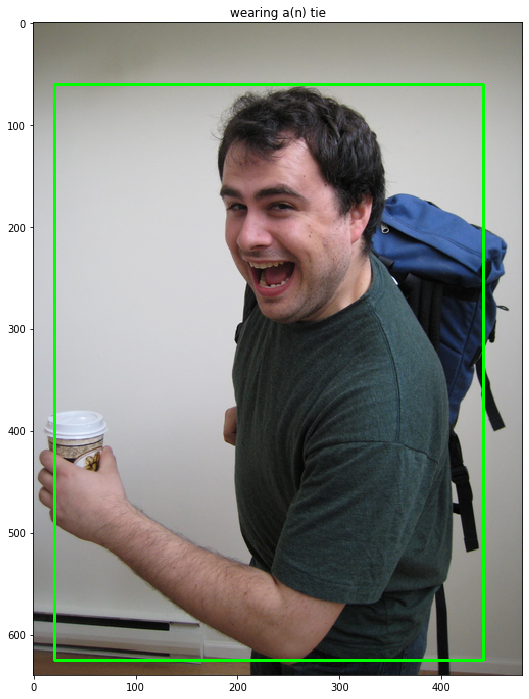

In [57]:
im = cv2.imread(IMG_PATH,1)
for bbox in human_bboxes:
    cv2.rectangle(im, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
for bbox in object_bboxes:
    cv2.rectangle(im, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

im = im[:,:,::-1] 
plt.figure(figsize=(12,12))
plt.imshow(im)
if prediction['verb'] == 'no_interaction':
    plt.title('cool ' + prediction['object'])
else:
    plt.title(prediction['verb'] + 'ing a(n) ' + prediction['object'])
plt.show()